### PREDICTION CHALLENGE TASK II & III

## 1. Import Libraries, Data and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data = pd.read_csv('Clustering_Data.csv')
data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480683 entries, 0 to 17480682
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   start_station_id         float64
 1   start_station_latitude   float64
 2   start_station_longitude  float64
 3   end_station_id           float64
 4   end_station_latitude     float64
 5   end_station_longitude    float64
 6   bikeid                   int64  
 7   usertype                 int64  
 8   gender                   int64  
 9   start_time               object 
 10  stop_time                object 
 11  tripduration_min         float64
 12  age                      int64  
 13  start_cluster_20         int64  
 14  end_cluster_20           int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 2.0+ GB


In [4]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data = data[data['start_time'].dt.year == 2018]
data = data[data['stop_time'].dt.year == 2018]

data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


## 2. Pickups and Dropoffs Prediction 

### 2.1 Time Series Analysis Model

Given a specific cluster, we filter the data by keeping only trips whose starting station belongs to the named cluster. You can use the clusters_map.html that we created in the **Prediction_Challenge_Clustering.ipynb** notebook in order to decide what cluster you want to predict pickups and demands.

In [28]:
#We suggest clusters 2,3,15
target_clusters = [15]

data_filtered = data[data['start_cluster_20'].isin(target_clusters)].copy()

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026240 entries, 10984 to 17480615
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   start_station_id         float64       
 1   start_station_latitude   float64       
 2   start_station_longitude  float64       
 3   end_station_id           float64       
 4   end_station_latitude     float64       
 5   end_station_longitude    float64       
 6   bikeid                   int64         
 7   usertype                 int64         
 8   gender                   int64         
 9   start_time               datetime64[ns]
 10  stop_time                datetime64[ns]
 11  tripduration_min         float64       
 12  age                      int64         
 13  start_cluster_20         int64         
 14  end_cluster_20           int64         
dtypes: datetime64[ns](2), float64(7), int64(6)
memory usage: 247.3 MB


### 2.1.1 Pickups Prediction

In [29]:
# Create pickup hour and date columns
data_filtered['pickup_hour'] = data_filtered['start_time'].dt.hour
data_filtered['date'] = data_filtered['start_time'].dt.date

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026240 entries, 10984 to 17480615
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   start_station_id         float64       
 1   start_station_latitude   float64       
 2   start_station_longitude  float64       
 3   end_station_id           float64       
 4   end_station_latitude     float64       
 5   end_station_longitude    float64       
 6   bikeid                   int64         
 7   usertype                 int64         
 8   gender                   int64         
 9   start_time               datetime64[ns]
 10  stop_time                datetime64[ns]
 11  tripduration_min         float64       
 12  age                      int64         
 13  start_cluster_20         int64         
 14  end_cluster_20           int64         
 15  pickup_hour              int32         
 16  date                     object        
dtypes: datetime64[ns](2), float

In [30]:
# Count pickups per hour, per day (for one cluster)
cluster_hourly = (
    data_filtered
    .groupby(['date', 'pickup_hour'])
    ['start_station_id']
    .size()
    .reset_index()
    .rename(columns={'start_station_id': 'pickups'})
)
cluster_hourly.head()

,date,pickup_hour,pickups
0,2018-01-01,0,15
1,2018-01-01,1,28
2,2018-01-01,2,12
3,2018-01-01,3,12
4,2018-01-01,4,3


In [31]:
cluster_hourly['datetime'] = pd.to_datetime(
    cluster_hourly['date'].astype(str) + ' ' +
    cluster_hourly['pickup_hour'].astype(str) + ':00:00'
)
cluster_hourly = cluster_hourly.sort_values('datetime')

In [32]:
# Ensure datetime index and hourly frequency
chd = (
    cluster_hourly
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'pickups': 0})  # fill missing hours if any
)

# Make sure we only keep 2018 samples
chd_2018 = chd.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data = chd.loc['2018-01-01':'2018-10-31 23:00', 'pickups']

# Test: Nov–Dec 2018
test_data  = chd.loc['2018-11-01 00:00':'2018-12-31 23:00', 'pickups']

C:\Users\billy\AppData\Local\Temp\ipykernel_17908\495717343.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_17908\430030329.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')


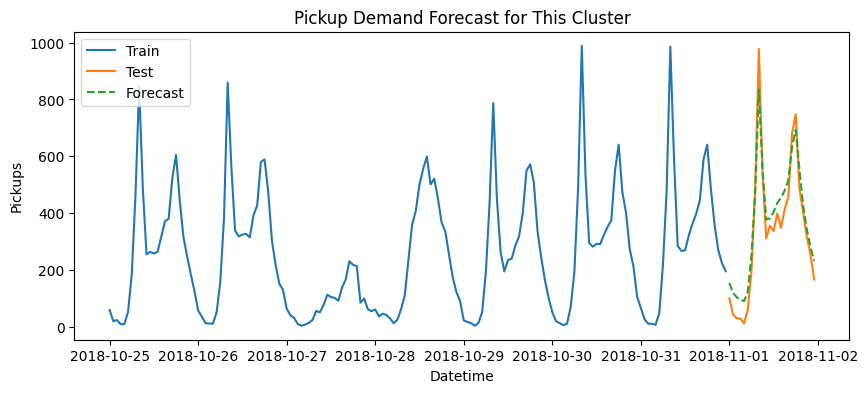

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model for this cluster
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data.index[-1]
forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[-24*7:], label='Train')
plt.plot(test_data[:24], label='Test')
plt.plot(forecast_index, forecast, '--', label='Forecast')
plt.title('Pickup Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Pickups')
plt.legend()
plt.show()

Mean Absolute Error for Pickups Prediction

In [34]:
y_true = chd_2018.loc['2018-11-01','pickups']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 57.27050398731557
RMSE is 64.04297205997551


### 2.1.2 Dropoffs Prediction

In [16]:
data_filtered_dropoffs = data[data['end_cluster_20'].isin(target_clusters)].copy()

data_filtered_dropoffs['dropoff_hour'] = data_filtered['stop_time'].dt.hour.astype("Int32")
data_filtered_dropoffs['date'] = data_filtered['stop_time'].dt.date

data_filtered_dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988322 entries, 1365 to 17480669
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_station_id         988322 non-null  float64       
 1   start_station_latitude   988322 non-null  float64       
 2   start_station_longitude  988322 non-null  float64       
 3   end_station_id           988322 non-null  float64       
 4   end_station_latitude     988322 non-null  float64       
 5   end_station_longitude    988322 non-null  float64       
 6   bikeid                   988322 non-null  int64         
 7   usertype                 988322 non-null  int64         
 8   gender                   988322 non-null  int64         
 9   start_time               988322 non-null  datetime64[ns]
 10  stop_time                988322 non-null  datetime64[ns]
 11  tripduration_min         988322 non-null  float64       
 12  age             

In [17]:
# Count dropoffs per hour, per day (for this cluster)
cluster_hourly_drops = (
    data_filtered_dropoffs
    .groupby(['date', 'dropoff_hour'])
    ['end_station_id']
    .size()
    .reset_index()
    .rename(columns={'end_station_id': 'dropoffs'})
)


In [18]:
cluster_hourly_drops['datetime'] = pd.to_datetime(
    cluster_hourly_drops['date'].astype(str) + ' ' +
    cluster_hourly_drops['dropoff_hour'].astype(str) + ':00:00'
)
cluster_hourly_drops = cluster_hourly_drops.sort_values('datetime')
cluster_hourly_drops.head()

,date,dropoff_hour,dropoffs,datetime
0,2018-01-01,0,2,2018-01-01 00:00:00
1,2018-01-01,1,3,2018-01-01 01:00:00
2,2018-01-01,2,4,2018-01-01 02:00:00
3,2018-01-01,3,2,2018-01-01 03:00:00
4,2018-01-01,4,3,2018-01-01 04:00:00


In [19]:
# Ensure datetime index and hourly frequency
chd_drop = (
    cluster_hourly_drops
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'dropoffs': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018_drop = chd_drop.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data_drop = chd_2018_drop.loc['2018-01-01':'2018-10-31 23:00', 'dropoffs']
print(train_data_drop)

# Test: Nov–Dec 2018
test_data_drop  = chd_2018_drop.loc['2018-11-01 00:00':'2018-12-31 23:00', 'dropoffs']


datetime
2018-01-01 00:00:00      2.0
2018-01-01 01:00:00      3.0
2018-01-01 02:00:00      4.0
2018-01-01 03:00:00      2.0
2018-01-01 04:00:00      3.0
                       ...  
2018-10-31 19:00:00    104.0
2018-10-31 20:00:00     64.0
2018-10-31 21:00:00     59.0
2018-10-31 22:00:00     45.0
2018-10-31 23:00:00     28.0
Freq: h, Name: dropoffs, Length: 7296, dtype: float64


C:\Users\billy\AppData\Local\Temp\ipykernel_17908\490359717.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\billy\AppData\Local\Temp\ipykernel_17908\1894603461.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')


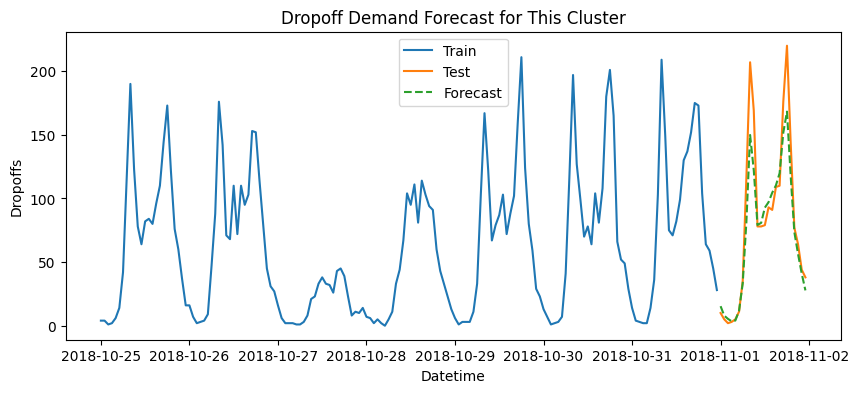

In [20]:
# Fit ARIMA model for this cluster
model = SARIMAX(train_data_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast_drop = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data_drop.index[-1]
forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data_drop[-24*7:], label='Train')
plt.plot(test_data_drop[:24], label='Test')
plt.plot(forecast_drop_index, forecast_drop, '--', label='Forecast')
plt.title('Dropoff Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Dropoffs')
plt.legend()
plt.show()

In [21]:
y_true = chd_2018_drop.loc['2018-11-01','dropoffs']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 54.98733846308429
RMSE is 72.28764312085944


## 3. Neural Networks Model

In [4]:
data_nn = data.copy()

In [5]:
data_nn['pickup_time']  = data_nn['start_time'].dt.floor('h')
data_nn['dropoff_time'] = data_nn['stop_time'].dt.floor('h')

In [6]:
pickup_ts = (
    data_nn
    .groupby(['start_cluster_20', pd.Grouper(key='pickup_time', freq='H')])
    .size()
    .rename('pickups')
    .reset_index()
    .rename(columns={'start_cluster_20': 'cluster',
                     'pickup_time': 'time'})
)

dropoff_ts = (
    data_nn
    .groupby(['end_cluster_20', pd.Grouper(key='dropoff_time', freq='H')])
    .size()
    .rename('dropoffs')
    .reset_index()
    .rename(columns={'end_cluster_20': 'cluster',
                     'dropoff_time': 'time'})
)

cluster_hour_ts = (
    pickup_ts
    .merge(dropoff_ts, on=['cluster', 'time'], how='outer')
    .fillna(0)
    .sort_values(['cluster', 'time'])
)

cluster_hour_ts.head()

C:\Users\user\AppData\Local\Temp\ipykernel_15516\3474213069.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(['start_cluster_20', pd.Grouper(key='pickup_time', freq='H')])
C:\Users\user\AppData\Local\Temp\ipykernel_15516\3474213069.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(['end_cluster_20', pd.Grouper(key='dropoff_time', freq='H')])


,cluster,time,pickups,dropoffs
0,0,2018-01-01 00:00:00,11.0,5.0
1,0,2018-01-01 01:00:00,6.0,9.0
2,0,2018-01-01 02:00:00,5.0,7.0
3,0,2018-01-01 03:00:00,3.0,2.0
4,0,2018-01-01 05:00:00,3.0,2.0


In [7]:
cluster_id = 15

cluster_ts = (
    cluster_hour_ts[cluster_hour_ts['cluster'] == cluster_id]
    .copy()
)

In [8]:
print(cluster_ts.head())
print(cluster_ts.shape)
print(cluster_ts.info())

cluster_ts = cluster_ts.drop(columns=['cluster'])

        cluster                time  pickups  dropoffs
120430       15 2018-01-01 00:00:00     15.0      13.0
120431       15 2018-01-01 01:00:00     28.0      32.0
120432       15 2018-01-01 02:00:00     12.0      15.0
120433       15 2018-01-01 03:00:00     12.0      14.0
120434       15 2018-01-01 04:00:00      3.0       6.0
(8740, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 8740 entries, 120430 to 129169
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cluster   8740 non-null   int64         
 1   time      8740 non-null   datetime64[ns]
 2   pickups   8740 non-null   float64       
 3   dropoffs  8740 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 341.4 KB
None


In [9]:
cluster_ts['time']=pd.to_datetime(cluster_ts['time'])
cluster_ts = cluster_ts.set_index('time').asfreq('h')
cluster_ts['pickups'] = cluster_ts['pickups'].fillna(0)
cluster_ts['dropoffs'] = cluster_ts['dropoffs'].fillna(0)

In [65]:
cluster_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pickups   8760 non-null   float64
 1   dropoffs  8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


In [11]:
del pickup_ts, dropoff_ts, cluster_hour_ts

In [94]:
df = cluster_ts.copy()
df = df[['pickups']].astype('float32')

train_val_mask = df.index <= '2018-10-31 23:00:00'

scaler = MinMaxScaler()
df.loc[train_val_mask, 'pickups'] = scaler.fit_transform(
    df.loc[train_val_mask, ['pickups']]
).ravel()
df.loc[~train_val_mask, 'pickups'] = scaler.transform(
    df.loc[~train_val_mask, ['pickups']]
).ravel()

In [95]:
# ----- reshape to (365, 24): each row = one day, each column = hour of the day -----
daily = df['pickups'].groupby(df.index.date).apply(list)     # 365 lists of length 24
daily_values = np.array(daily.to_list(), dtype=np.float32)   # shape (365, 24)
dates = np.array(list(daily.index))   

In [96]:
daily_values.shape

(365, 24)

In [ ]:
def make_samples_with_dates(daily_values, dates, input_days=7):
    """
    daily_values: (num_days, 24)
    dates:        (num_days,) datetime.date for each row in daily_values
    """
    num_days, steps_per_day = daily_values.shape

    X_train_days, y_train, train_dates = [], [], []
    X_test_days,  y_test,  test_dates  = [], [], []

    for d in range(input_days - 1, num_days - 1):  # last input day index
        x_days = daily_values[d - input_days + 1 : d + 1]    # (input_days, 24)
        target_idx = d + 1
        y_day = daily_values[target_idx]                     # (24,)
        target_date = dates[target_idx]

        if target_date <= pd.to_datetime('2018-10-31').date():
            X_train_days.append(x_days)
            y_train.append(y_day)
            train_dates.append(target_date)
        else:
            X_test_days.append(x_days)
            y_test.append(y_day)
            test_dates.append(target_date)

    return (
        np.stack(X_train_days), np.stack(y_train), np.array(train_dates),
        np.stack(X_test_days),  np.stack(y_test),  np.array(test_dates),
    )

input_days = 7  # you can change this
X_train_days, y_train, train_dates, X_test_days, y_test, test_dates = \
    make_samples_with_dates(daily_values, dates, input_days=input_days)


In [98]:
print(X_train_days.shape)
print(y_train.shape)
print(train_dates.shape)
print(X_test_days.shape)
print(y_test.shape)
print(test_dates.shape)

(274, 30, 24)
(274, 24)
(274,)
(61, 30, 24)
(61, 24)
(61,)


In [99]:
val_size = 30  # days

X_train_days_final = X_train_days[:-val_size]
y_train_final       = y_train[:-val_size]

X_val_days          = X_train_days[-val_size:]
y_val               = y_train[-val_size:]


In [100]:
print(X_train_days_final.shape)
print(y_train_final.shape)
print(X_val_days.shape)
print(y_val.shape)

(244, 30, 24)
(244, 24)
(30, 30, 24)
(30, 24)


In [101]:
steps_per_day = 24

def to_lstm_shape(X_days, input_days, steps_per_day=24):
    n_samples = X_days.shape[0]
    return X_days.reshape(n_samples, input_days * steps_per_day, 1)

X_train = to_lstm_shape(X_train_days_final, input_days)
X_val   = to_lstm_shape(X_val_days,        input_days)
X_test  = to_lstm_shape(X_test_days,       input_days)

# Final shapes:
# X_train: (267, 168, 1)
# y_train: (267, 24)
# X_val:   (30,  168, 1)
# y_val:   (30,  24)
# X_test:  (61,  168, 1)
# y_test:  (61,  24)


In [102]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train_final.shape)
print(y_val.shape)
print(y_test.shape)

(244, 720, 1)
(30, 720, 1)
(61, 720, 1)
(244, 24)
(30, 24)
(61, 24)


In [103]:
timesteps  = X_train.shape[1]   # 168
n_features = X_train.shape[2]   # 1

def build_model(units1=128, units2=64, dense_units=64,
                dropout_rate=0.2, lr=1e-3):
    model = Sequential([
        LSTM(units1, return_sequences=True,
             input_shape=(timesteps, n_features)),
        Dropout(dropout_rate),
        LSTM(units2),
        Dense(dense_units, activation='relu'),
        Dense(24)  # 24-hour forecast
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',        # training objective
        metrics=['mae']    # monitor also MAE
    )
    return model

model = build_model()
model.summary()


c:\Users\user\Documents\GitHub\city-bike\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 720, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 720, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,688 (475.34 KB)

 Trainable params: 121,688 (475.34 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
configs = [
    {'u1': 64,  'u2': 32,  'dense': 32,  'drop': 0.1, 'lr': 1e-3},
    {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.2, 'lr': 1e-3},
    {'u1': 128, 'u2': 64,  'dense': 64,  'drop': 0.3, 'lr': 5e-4},
    {'u1': 256, 'u2': 128, 'dense': 64,  'drop': 0.3, 'lr': 1e-3},
]

best_cfg = None
best_val = np.inf

for cfg in configs:
    print('Config:', cfg)
    model_tmp = build_model(
        units1=cfg['u1'],
        units2=cfg['u2'],
        dense_units=cfg['dense'],
        dropout_rate=cfg['drop'],
        lr=cfg['lr']
    )
    es_tmp = EarlyStopping(monitor='val_loss', patience=10,
                           restore_best_weights=True, verbose=0)
    hist = model_tmp.fit(
        X_train, y_train_final,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        shuffle=False,
        callbacks=[es_tmp],
        verbose=0
    )
    val_best = min(hist.history['val_loss'])
    print(f'  best val_loss = {val_best:.5f}')

    if val_best < best_val:
        best_val = val_best
        best_cfg = cfg
        best_model = model_tmp  # keep reference to best one

print('Best config:', best_cfg, 'val_loss:', best_val)


Config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001}


c:\Users\user\Documents\GitHub\city-bike\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  best val_loss = 0.01237
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.2, 'lr': 0.001}
  best val_loss = 0.01295
Config: {'u1': 128, 'u2': 64, 'dense': 64, 'drop': 0.3, 'lr': 0.0005}
  best val_loss = 0.01244
Config: {'u1': 256, 'u2': 128, 'dense': 64, 'drop': 0.3, 'lr': 0.001}
  best val_loss = 0.01273
Best config: {'u1': 64, 'u2': 32, 'dense': 32, 'drop': 0.1, 'lr': 0.001} val_loss: 0.012368826195597649


In [104]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,          # epochs with no improvement
    restore_best_weights=True
)

mc = ModelCheckpoint(
    'best_lstm.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=False,        # keep chronological order of samples if required
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 0.0551 - mae: 0.1768
Epoch 1: val_loss improved from None to 0.05453, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - loss: 0.0671 - mae: 0.1991 - val_loss: 0.0545 - val_mae: 0.1824
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 0.0280 - mae: 0.1252
Epoch 2: val_loss improved from 0.05453 to 0.02604, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - loss: 0.0313 - mae: 0.1325 - val_loss: 0.0260 - val_mae: 0.1218
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 0.0164 - mae: 0.0954
Epoch 3: val_loss improved from 0.02604 to 0.01589, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - loss: 0.0182 - mae: 0.0999 - val_loss: 0.0159 - val_mae: 0.0886
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0121 - mae: 0.0768
Epoch 4: val_loss improved from 0.01589 to 0.01348, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - loss: 0.0138 - mae: 0.0822 - val_loss: 0.0135 - val_mae: 0.0766
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.0118 - mae: 0.0740
Epoch 5: val_loss improved from 0.01348 to 0.01314, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 604ms/step - loss: 0.0132 - mae: 0.0784 - val_loss: 0.0131 - val_mae: 0.0757
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - loss: 0.0114 - mae: 0.0723
Epoch 6: val_loss did not improve from 0.01314
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step - loss: 0.0130 - mae: 0.0775 - val_loss: 0.0133 - val_mae: 0.0773
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - loss: 0.0111 - mae: 0.0714
Epoch 7: val_loss did not improve from 0.01314
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - loss: 0.0127 - mae: 0.0767 - val_loss: 0.0133 - val_mae: 0.0767
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.0111 - mae: 0.0712
Epoch 8: val_loss improved from 0.01314 to 0.01310, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step - loss: 0.0127 - mae: 0.0763 - val_loss: 0.0131 - val_mae: 0.0750
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 0.0110 - mae: 0.0703
Epoch 9: val_loss improved from 0.01310 to 0.01306, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 714ms/step - loss: 0.0126 - mae: 0.0754 - val_loss: 0.0131 - val_mae: 0.0746
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.0108 - mae: 0.0696
Epoch 10: val_loss improved from 0.01306 to 0.01305, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step - loss: 0.0125 - mae: 0.0752 - val_loss: 0.0131 - val_mae: 0.0745
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.0107 - mae: 0.0689
Epoch 11: val_loss did not improve from 0.01305
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - loss: 0.0125 - mae: 0.0747 - val_loss: 0.0131 - val_mae: 0.0750
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - loss: 0.0109 - mae: 0.0694
Epoch 12: val_loss improved from 0.01305 to 0.01304, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 577ms/step - loss: 0.0125 - mae: 0.0748 - val_loss: 0.0130 - val_mae: 0.0747
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.0107 - mae: 0.0689
Epoch 13: val_loss improved from 0.01304 to 0.01302, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step - loss: 0.0124 - mae: 0.0745 - val_loss: 0.0130 - val_mae: 0.0747
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.0107 - mae: 0.0687
Epoch 14: val_loss did not improve from 0.01302
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step - loss: 0.0123 - mae: 0.0744 - val_loss: 0.0131 - val_mae: 0.0751
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.0107 - mae: 0.0687
Epoch 15: val_loss did not improve from 0.01302
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - loss: 0.0123 - mae: 0.0744 - val_loss: 0.0131 - val_mae: 0.0754
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 0.0107 - mae: 0.0688
Epoch 16: val_loss improved from 0.01302 to 0.01298, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - loss: 0.0124 - mae: 0.0746 - val_loss: 0.0130 - val_mae: 0.0747
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.0105 - mae: 0.0678
Epoch 17: val_loss improved from 0.01298 to 0.01298, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - loss: 0.0122 - mae: 0.0739 - val_loss: 0.0130 - val_mae: 0.0747
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - loss: 0.0104 - mae: 0.0678
Epoch 18: val_loss did not improve from 0.01298
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step - loss: 0.0121 - mae: 0.0738 - val_loss: 0.0130 - val_mae: 0.0751
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 0.0105 - mae: 0.0679
Epoch 19: val_loss did not improve from 0.01298
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - loss: 0.0122 - mae: 0.0738 - val_loss: 0.0130 - val_mae: 0.0752
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.0104 - mae: 0.0677
Epoch 20: val_loss did not improve from 0.01298
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - loss: 0.0121 - mae: 0.0737 - val_loss: 0.0131 - val_mae: 0.0764
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.0104 - mae: 0.0676
Epoch 21: val_loss did not improve from 0.01298
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 577ms/step - loss: 0.0121 - mae: 0.0736

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step - loss: 0.0118 - mae: 0.0730 - val_loss: 0.0126 - val_mae: 0.0729
Epoch 24/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.0096 - mae: 0.0652
Epoch 24: val_loss did not improve from 0.01256
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step - loss: 0.0114 - mae: 0.0720 - val_loss: 0.0128 - val_mae: 0.0761
Epoch 25/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - loss: 0.0099 - mae: 0.0657
Epoch 25: val_loss did not improve from 0.01256
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step - loss: 0.0118 - mae: 0.0727 - val_loss: 0.0129 - val_mae: 0.0731
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - loss: 0.0095 - mae: 0.0647
Epoch 26: val_loss did not improve from 0.01256
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 650ms/step - loss: 0.0114 - mae: 0.0715 - val_loss: 0.0126 - val_mae: 0.0748
Epoch 27/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.0103 - mae: 0.0675
Epoch 27: val_loss did not improve from 0.01256
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 627ms/step - loss: 0.0119 - mae: 0.0734 

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step - loss: 0.0123 - mae: 0.0749 - val_loss: 0.0122 - val_mae: 0.0718
Epoch 29/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - loss: 0.0099 - mae: 0.0661
Epoch 29: val_loss did not improve from 0.01222
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 652ms/step - loss: 0.0115 - mae: 0.0719 - val_loss: 0.0123 - val_mae: 0.0728
Epoch 30/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - loss: 0.0092 - mae: 0.0634
Epoch 30: val_loss improved from 0.01222 to 0.01186, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 694ms/step - loss: 0.0109 - mae: 0.0704 - val_loss: 0.0119 - val_mae: 0.0715
Epoch 31/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.0090 - mae: 0.0631
Epoch 31: val_loss improved from 0.01186 to 0.01182, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 584ms/step - loss: 0.0106 - mae: 0.0697 - val_loss: 0.0118 - val_mae: 0.0721
Epoch 32/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 0.0093 - mae: 0.0641
Epoch 32: val_loss did not improve from 0.01182
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step - loss: 0.0108 - mae: 0.0702 - val_loss: 0.0132 - val_mae: 0.0795
Epoch 33/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - loss: 0.0101 - mae: 0.0682
Epoch 33: val_loss did not improve from 0.01182
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step - loss: 0.0112 - mae: 0.0719 - val_loss: 0.0120 - val_mae: 0.0730
Epoch 34/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - loss: 0.0106 - mae: 0.0695
Epoch 34: val_loss improved from 0.01182 to 0.01176, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step - loss: 0.0117 - mae: 0.0732 - val_loss: 0.0118 - val_mae: 0.0711
Epoch 35/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.0096 - mae: 0.0650
Epoch 35: val_loss did not improve from 0.01176
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - loss: 0.0110 - mae: 0.0707 - val_loss: 0.0119 - val_mae: 0.0722
Epoch 36/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 0.0091 - mae: 0.0631
Epoch 36: val_loss did not improve from 0.01176
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 603ms/step - loss: 0.0107 - mae: 0.0692 - val_loss: 0.0118 - val_mae: 0.0715
Epoch 37/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 0.0091 - mae: 0.0629
Epoch 37: val_loss improved from 0.01176 to 0.01171, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 635ms/step - loss: 0.0107 - mae: 0.0692 - val_loss: 0.0117 - val_mae: 0.0716
Epoch 38/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - loss: 0.0090 - mae: 0.0630
Epoch 38: val_loss improved from 0.01171 to 0.01154, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 787ms/step - loss: 0.0107 - mae: 0.0692 - val_loss: 0.0115 - val_mae: 0.0705
Epoch 39/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - loss: 0.0089 - mae: 0.0619
Epoch 39: val_loss did not improve from 0.01154
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 673ms/step - loss: 0.0104 - mae: 0.0681 - val_loss: 0.0116 - val_mae: 0.0714
Epoch 40/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.0088 - mae: 0.0616
Epoch 40: val_loss did not improve from 0.01154
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 612ms/step - loss: 0.0104 - mae: 0.0679 - val_loss: 0.0116 - val_mae: 0.0724
Epoch 41/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.0088 - mae: 0.0616
Epoch 41: val_loss did not improve from 0.01154
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - loss: 0.0104 - mae: 0.0677 - val_loss: 0.0118 - val_mae: 0.0743
Epoch 42/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 0.0089 - mae: 0.0620
Epoch 42: val_loss improved from 0.01154 to 0.01147, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step - loss: 0.0106 - mae: 0.0685 - val_loss: 0.0115 - val_mae: 0.0702
Epoch 43/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.0091 - mae: 0.0628
Epoch 43: val_loss improved from 0.01147 to 0.01096, saving model to best_lstm.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step - loss: 0.0107 - mae: 0.0691 - val_loss: 0.0110 - val_mae: 0.0670
Epoch 44/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.0087 - mae: 0.0607
Epoch 44: val_loss did not improve from 0.01096
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - loss: 0.0104 - mae: 0.0673 - val_loss: 0.0110 - val_mae: 0.0684
Epoch 45/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - loss: 0.0083 - mae: 0.0593
Epoch 45: val_loss did not improve from 0.01096
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - loss: 0.0099 - mae: 0.0653 - val_loss: 0.0114 - val_mae: 0.0690
Epoch 46/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - loss: 0.0080 - mae: 0.0578
Epoch 46: val_loss did not improve from 0.01096
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step - loss: 0.0097 - mae: 0.0639 - val_loss: 0.0110 - val_mae: 0.0664
Epoch 47/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.0081 - mae: 0.0583
Epoch 47: val_loss did not improve from 0.01096
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - loss: 0.0095 - mae: 0.0639 

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 674ms/step - loss: 0.0098 - mae: 0.0648 - val_loss: 0.0108 - val_mae: 0.0682
Epoch 50/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.0082 - mae: 0.0585
Epoch 50: val_loss did not improve from 0.01082
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 559ms/step - loss: 0.0096 - mae: 0.0643 - val_loss: 0.0124 - val_mae: 0.0718


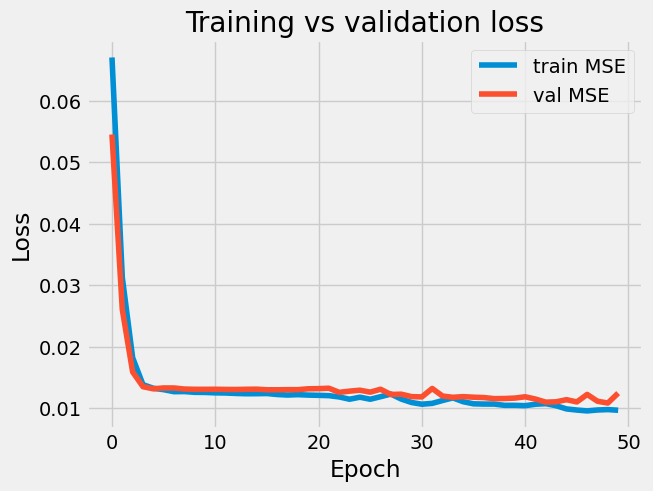

In [105]:
plt.figure()
plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs validation loss')
plt.show()

In [106]:
y_pred_scaled = model.predict(X_test)   # shape (N_test, 24)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step


In [107]:
# y_test and y_pred_scaled are in [0,1] (scaled)
# we need 2D arrays for scaler.inverse_transform

y_test_flat_scaled = y_test.reshape(-1, 1)
y_pred_flat_scaled = y_pred_scaled.reshape(-1, 1)

y_test_flat = scaler.inverse_transform(y_test_flat_scaled).ravel()
y_pred_flat = scaler.inverse_transform(y_pred_flat_scaled).ravel()

# reshape back to (N_days, 24)
y_test_inv = y_test_flat.reshape(y_test.shape)
y_pred_inv = y_pred_flat.reshape(y_pred_scaled.shape)


In [88]:
y_test_inv

array([[100.     ,  44.     ,  30.     , ..., 316.00003, 254.     ,
        167.     ],
       [ 73.     ,  33.     ,  27.     , ..., 140.     , 130.     ,
        120.     ],
       [112.     ,  72.     ,  22.     , ..., 188.     , 191.     ,
        152.     ],
       ...,
       [ 76.     ,  53.     ,  26.     , ..., 124.     ,  92.     ,
         83.     ],
       [ 46.     ,  39.     ,  34.     , ..., 120.     ,  80.     ,
         49.     ],
       [ 41.     ,  35.     ,  23.     , ...,  10.     ,  13.     ,
          1.     ]], shape=(61, 24), dtype=float32)

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# overall, all horizons flattened
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae  = mean_absolute_error(y_test_flat, y_pred_flat)
mape = np.mean(
    np.abs((y_test_flat - y_pred_flat) / (y_test_flat + 1e-8))
) * 100

print(f'Overall RMSE: {rmse:.2f}')
print(f'Overall MAE:  {mae:.2f}')
print(f'Overall MAPE: {mape:.2f}%')


Overall RMSE: 100.52
Overall MAE:  66.12
Overall MAPE: 81.78%


In [46]:
rmse_per_h = np.sqrt(np.mean((y_pred_inv - y_test_inv)**2, axis=0))
mae_per_h  = np.mean(np.abs(y_pred_inv - y_test_inv), axis=0)

for h, (r, m) in enumerate(zip(rmse_per_h, mae_per_h)):
    print(f'h+{h+1:02d}  RMSE={r:.2f}, MAE={m:.2f}')


h+01  RMSE=27.56, MAE=23.07
h+02  RMSE=22.20, MAE=19.66
h+03  RMSE=14.81, MAE=10.07
h+04  RMSE=11.70, MAE=9.71
h+05  RMSE=6.23, MAE=5.44
h+06  RMSE=16.85, MAE=14.17
h+07  RMSE=69.33, MAE=61.41
h+08  RMSE=156.26, MAE=139.77
h+09  RMSE=300.63, MAE=281.59
h+10  RMSE=129.75, MAE=111.17
h+11  RMSE=78.46, MAE=55.69
h+12  RMSE=93.84, MAE=77.28
h+13  RMSE=103.91, MAE=89.14
h+14  RMSE=105.96, MAE=84.62
h+15  RMSE=102.91, MAE=81.65
h+16  RMSE=115.01, MAE=86.18
h+17  RMSE=120.54, MAE=85.07
h+18  RMSE=153.60, MAE=109.29
h+19  RMSE=197.86, MAE=160.02
h+20  RMSE=169.63, MAE=140.42
h+21  RMSE=121.34, MAE=99.78
h+22  RMSE=79.63, MAE=63.88
h+23  RMSE=57.57, MAE=46.33
h+24  RMSE=43.28, MAE=35.03


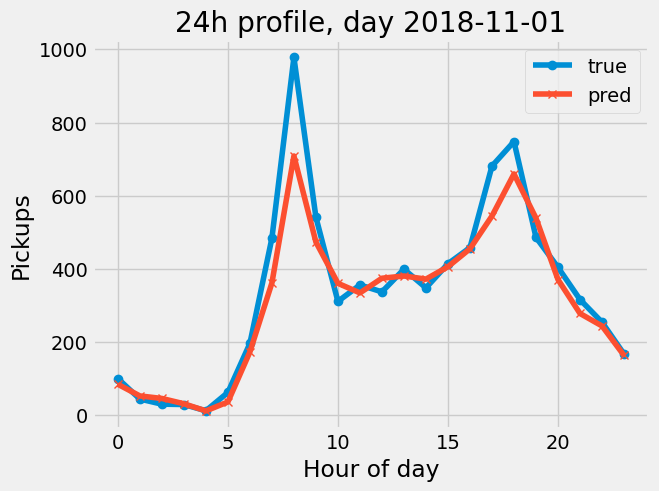

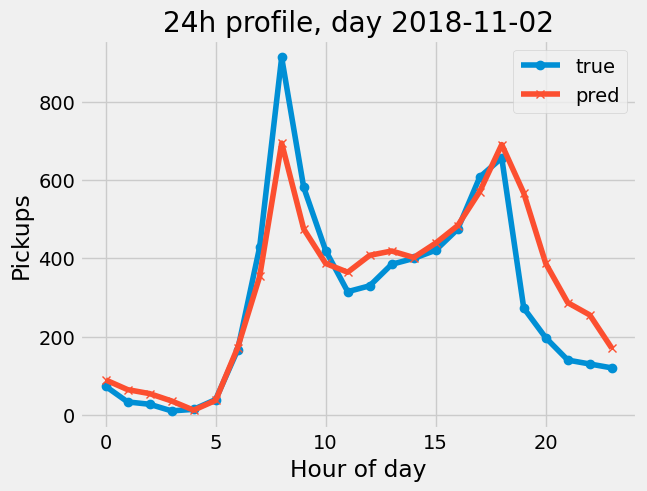

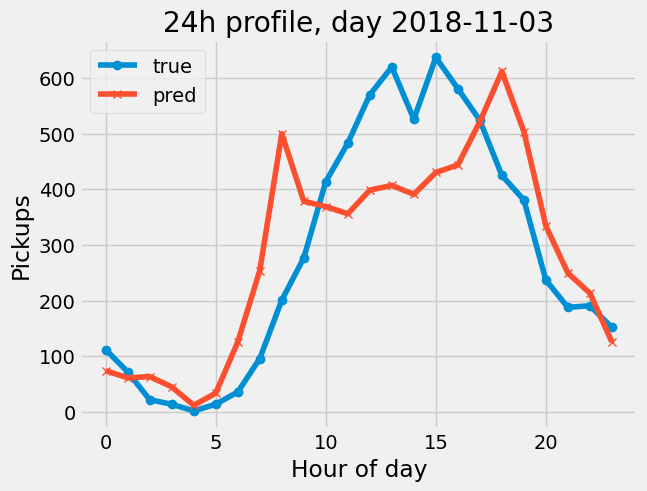

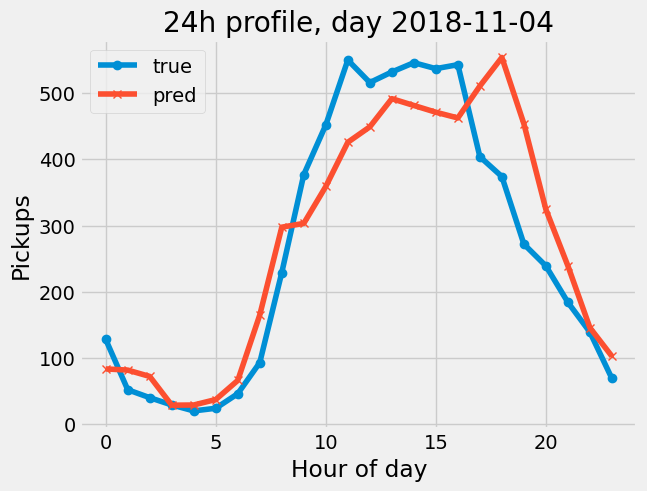

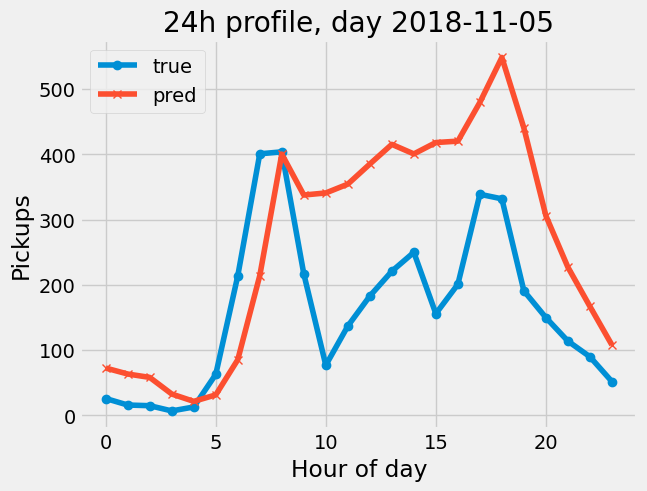

In [109]:
hours = np.arange(24)

n_plots =5   # first 5 test days, for example
for i in range(5):
    plt.figure()
    plt.plot(hours, y_test_inv[i], marker='o', label='true')
    plt.plot(hours, y_pred_inv[i], marker='x', label='pred')
    plt.xlabel('Hour of day')
    plt.ylabel('Pickups')
    plt.title(f'24h profile, day {test_dates[i]}')
    plt.legend()
    plt.grid(True)
    plt.show()


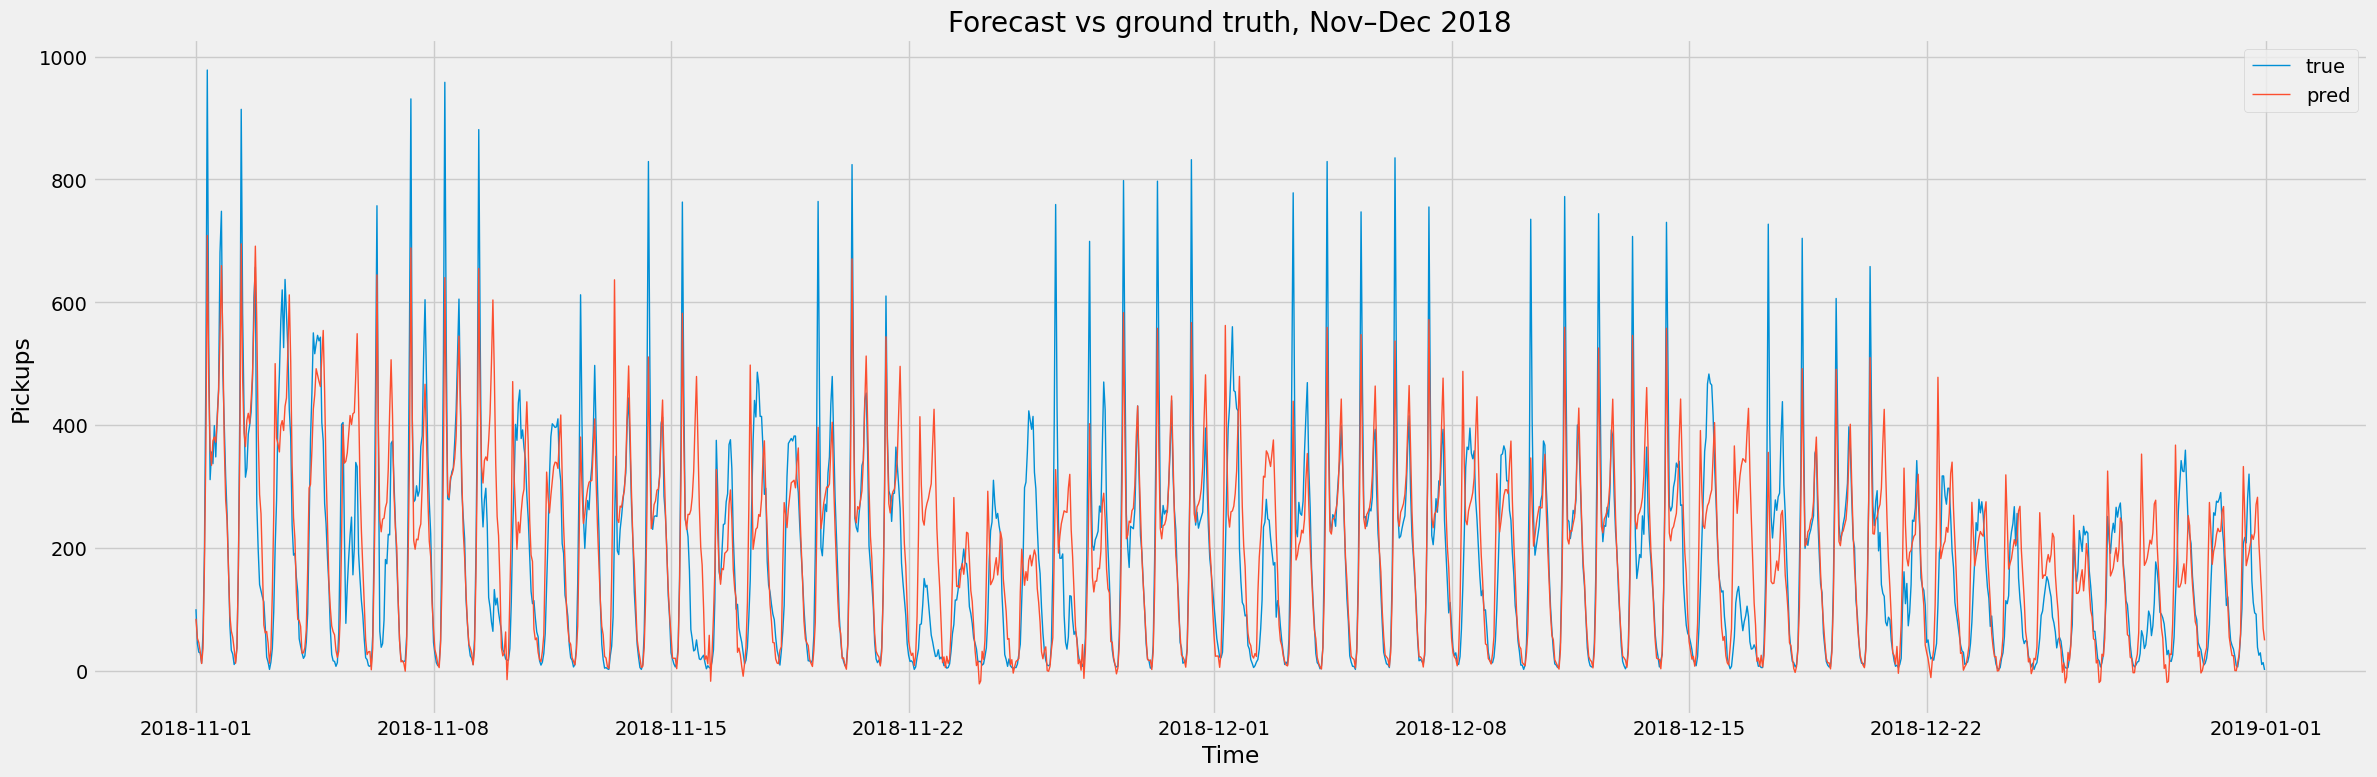

In [110]:
start = pd.to_datetime(test_dates[0])
full_index = pd.date_range(
    start=start,
    periods=24 * len(test_dates),
    freq='h'
)

true_series = y_test_inv.reshape(-1)
pred_series = y_pred_inv.reshape(-1)

plt.figure(figsize=(24, 8))
plt.plot(full_index, true_series, label='true', linewidth=1)
plt.plot(full_index, pred_series, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, Nov–Dec 2018')
plt.legend()
plt.tight_layout()
plt.show()


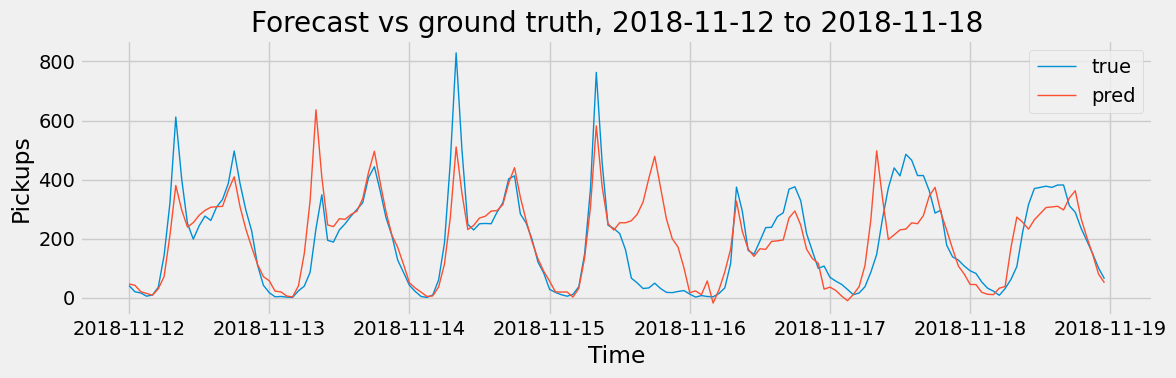

In [111]:
week_start = pd.to_datetime('2018-11-12')
week_end = week_start + pd.Timedelta(days=7)

mask = (full_index >= week_start) & (full_index < week_end)

week_index = full_index[mask]
week_true = true_series[mask]
week_pred = pred_series[mask]

plt.figure(figsize=(12, 4))
plt.plot(week_index, week_true, label='true', linewidth=1)
plt.plot(week_index, week_pred, label='pred', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.title('Forecast vs ground truth, 2018-11-12 to 2018-11-18')
plt.legend()
plt.tight_layout()
plt.show()


## 4. Model Comparison

## 5. Net Flow Prediction

This implementation is more interactive. We let the user pick the date they want to predict the number of bikes that need to be repositioned. Then, we dynamically select train and test dataset and use timeseries to find the hourly net flow of the cluster.

In [35]:
hourly_2018_pickups = chd_2018.loc['2018-01-01':'2018-12-31 23:00','pickups']
hourly_2018_dropoffs = chd_2018_drop.loc['2018-01-01':'2018-12-31 23:00','dropoffs']
hourly_2018_pickups_dropoffs = pd.concat([hourly_2018_pickups,hourly_2018_dropoffs], axis=1)
hourly_2018_pickups_dropoffs.head()

,pickups,dropoffs
datetime,,
2018-01-01 00:00:00,15.0,2.0
2018-01-01 01:00:00,28.0,3.0
2018-01-01 02:00:00,12.0,4.0
2018-01-01 03:00:00,12.0,2.0
2018-01-01 04:00:00,3.0,3.0


In the following user prompt, you should type '2018-11-01', to continue with the same split of train/test data as we have used in **2.1.1 1 & 2.1.2**. Feel free to experiment with different dates, as well. 

In [38]:
# Prompt the user to input the date
date_input = input("Enter the date for which you want to predict reposition needs (2018-MM-DD): ")

# Parse the input as a datetime
import datetime
try:
    target_date = datetime.datetime.strptime(date_input, "%Y-%m-%d").date()
    print(f"Processing reposition needs for: {target_date}")
except ValueError:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

Invalid date format. Please enter the date in YYYY-MM-DD format.


In [37]:
# Train data: Strictly before the given date
# Test data: Includes all dates from the input date and after
train_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'pickups']
test_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'pickups']

train_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'dropoffs']
test_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'dropoffs']


# Fit ARIMA model for this cluster
model1 = SARIMAX(train_net_pick, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted1 = model1.fit(disp=False)

model2 = SARIMAX(train_net_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted2 = model2.fit(disp=False)

# Forecast next 24 hours pickups and dropoffs
fc_pickups = fitted1.forecast(steps=24)
fc_dropoffs = fitted2.forecast(steps=24)


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [39]:
picks_forecast_df = pd.DataFrame(fc_pickups)
picks_forecast_df.columns = ['pickups']
picks_forecast_df.index.name = 'datetime'
#picks_forecast_df.info()

drops_forecast_df = pd.DataFrame(fc_dropoffs)
drops_forecast_df.columns = ['dropoffs']
drops_forecast_df.index.name = 'datetime'
#drops_forecast_df.info()

# Combine forecasts into one DataFrame
forecast_next_day = pd.concat([picks_forecast_df, drops_forecast_df], axis=1)
forecast_next_day

,pickups,dropoffs
datetime,,
2018-05-15 00:00:00,69.945931,13.881229
2018-05-15 01:00:00,49.551589,9.437835
2018-05-15 02:00:00,39.009459,7.516812
2018-05-15 03:00:00,34.216984,6.526415
2018-05-15 04:00:00,33.235034,6.609992
2018-05-15 05:00:00,58.785935,12.447198
2018-05-15 06:00:00,149.871178,30.657925
2018-05-15 07:00:00,337.913641,61.855167
2018-05-15 08:00:00,634.394736,116.407576


In [40]:
# Calculate net flow: pickups = departures
net_flow = forecast_next_day['pickups'] - forecast_next_day['dropoffs']
forecast_next_day['net'] = net_flow
forecast_next_day



,pickups,dropoffs,net
datetime,,,
2018-05-15 00:00:00,69.945931,13.881229,56.064702
2018-05-15 01:00:00,49.551589,9.437835,40.113753
2018-05-15 02:00:00,39.009459,7.516812,31.492647
2018-05-15 03:00:00,34.216984,6.526415,27.690569
2018-05-15 04:00:00,33.235034,6.609992,26.625042
2018-05-15 05:00:00,58.785935,12.447198,46.338738
2018-05-15 06:00:00,149.871178,30.657925,119.213253
2018-05-15 07:00:00,337.913641,61.855167,276.058474
2018-05-15 08:00:00,634.394736,116.407576,517.987161


In [41]:
mask = forecast_next_day.index.date == target_date
day_netflow = forecast_next_day.loc[mask, 'net'].max()

# Required bikes at start of day
required_bikes = math.ceil(max(0, day_netflow))
print(f"Number of bikes to reposition on {target_date} is: {required_bikes}")

Number of bikes to reposition on 2018-05-15 is: 518
